# Assignment Set 11

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU

In [ ]:
%ls ../input/emotions-dataset-for-nlp/
%mkdir data/

test.txt  train.txt  val.txt


In [ ]:
df_train = pd.read_csv('../input/emotions-dataset-for-nlp/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../input/emotions-dataset-for-nlp/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../input/emotions-dataset-for-nlp/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

df_train.to_csv('data/train.csv',index=False)
df_test.to_csv('data/test.csv',index=False)
df_val.to_csv('data/val.csv',index=False)

In [ ]:
def clean_text(texts):
    cleaned_text = []
    for text in texts:
        text = re.sub('[!#?,.:";]', ' ', text)
        text = re.sub(r' +', ' ', text)
        text = re.sub(r'\n', ' ', text)
        cleaned_text.append(text)
    return cleaned_text
    
def accuracy(probs, target):
    winners = probs.argmax(dim=1)
    corrects = (winners == target)
    accuracy = corrects.sum().float() / float(target.size(0))
    return accuracy 

In [ ]:
def train(model, iterator, optimizer, loss_fn):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        text_lengths = text_lengths.to('cpu')
        predictions = model(text, text_lengths)
        loss = loss_fn(predictions, batch.sentiment.squeeze())
        acc = accuracy(predictions, batch.sentiment)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, loss_fn):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            text_lengths = text_lengths.to('cpu')
            predictions = model(text, text_lengths).squeeze(1)
            loss = loss_fn(predictions, batch.sentiment)
            acc = accuracy(predictions, batch.sentiment)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
maxlen = 90
batch_size = 32
numwords = 1024
lr = 1e-4
num_epochs = 10

Text = data.Field(preprocessing=clean_text, tokenize=lambda x:x.split(), batch_first=True, include_lengths=True, fix_length=300)
Sentiment = data.Field(sequential=False, use_vocab=True, pad_token=None, unk_token=None)

fields = [('text', Text), ('sentiment', Sentiment)]

train_data,val_data, test_data = data.TabularDataset.splits(
    path='data/',
    train= 'train.csv',
    validation = 'val.csv',
    test= 'test.csv',
    format='csv',
    fields=fields,
    skip_header=True
    )
[len(d.examples) for d in [train_data,val_data,test_data]]

Text.build_vocab(train_data, max_size=numwords)
Sentiment.build_vocab(train_data)
vocab_size = len(Text.vocab)
print(vocab_size)
print(len(Sentiment.vocab))

1026
6


In [ ]:
# model 1
class LSTM1(nn.Module):
    def __init__(self, vocab_size, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 1024, padding_idx = pad_index)
        self.lstm = nn.LSTM(1024,
                            128,
                            num_layers=2,
                            bidirectional=False,
                            batch_first=True)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 6)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.3)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True) 

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        rel = self.relu(cat)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        return preds

# model 2
class LSTM2(nn.Module):
    def __init__(self, vocab_size, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 2048, padding_idx = pad_index)
        self.lstm = nn.LSTM(2048,
                            512,
                            num_layers=2,
                            bidirectional=True,
                            batch_first=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 6)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.3)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True) 

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        rel = self.relu(cat)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        return preds

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
train_iterator, val_iterator, test_iterator = BucketIterator.splits((train_data, val_data, test_data),
        batch_size = batch_size,
        sort_key = lambda x: len(x.text),
        sort_within_batch = True,
        device = device)

pad_index = Text.vocab.stoi[Text.pad_token]
loss_func = nn.CrossEntropyLoss()

mdl_pool = {'lstm1':
            {'mdl':LSTM1(vocab_size,pad_index),
             'val_acc':[],
             'train_acc':[]},
            'lstm2':
            {'mdl':LSTM2(vocab_size,pad_index),
             'val_acc':[],
             'train_acc':[]}}

for name,item in mdl_pool.items():
    model = item['mdl'] 
    print(name)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, loss_func)
        val_loss, val_acc = evaluate(model, val_iterator, loss_func)
        item['val_acc'].append(val_acc)
        item['train_acc'].append(train_acc)
        print(f'   Train Loss: {train_loss:.3f} \t| Train Acc: {train_acc * 100:.2f}%')
        print(f'   Val Loss: {val_loss:.3f} \t| Val Acc: {val_acc * 100:.2f}%')

cuda
lstm1
   Train Loss: 1.598 	| Train Acc: 34.92%
   Val Loss: 1.549 	| Val Acc: 38.94%
   Train Loss: 1.414 	| Train Acc: 44.70%
   Val Loss: 1.217 	| Val Acc: 56.10%
   Train Loss: 0.987 	| Train Acc: 63.91%
   Val Loss: 0.908 	| Val Acc: 66.47%
   Train Loss: 0.770 	| Train Acc: 71.34%
   Val Loss: 0.802 	| Val Acc: 69.74%
   Train Loss: 0.673 	| Train Acc: 74.83%
   Val Loss: 0.769 	| Val Acc: 71.03%
   Train Loss: 0.573 	| Train Acc: 78.49%
   Val Loss: 0.721 	| Val Acc: 73.86%
   Train Loss: 0.506 	| Train Acc: 81.12%
   Val Loss: 0.695 	| Val Acc: 75.60%
   Train Loss: 0.423 	| Train Acc: 84.09%
   Val Loss: 0.651 	| Val Acc: 77.03%
   Train Loss: 0.356 	| Train Acc: 86.92%
   Val Loss: 0.653 	| Val Acc: 79.41%
   Train Loss: 0.292 	| Train Acc: 90.03%
   Val Loss: 0.621 	| Val Acc: 81.40%
lstm2
   Train Loss: 1.185 	| Train Acc: 55.17%
   Val Loss: 0.723 	| Val Acc: 74.75%
   Train Loss: 0.436 	| Train Acc: 84.75%
   Val Loss: 0.411 	| Val Acc: 84.82%
   Train Loss: 0.267 	|

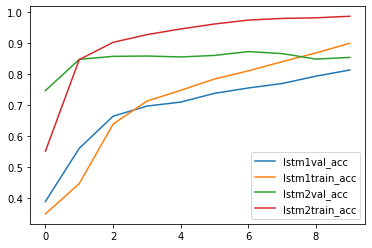

In [ ]:
colors = 
for name,item in mdl_pool.items():
    plt.plot(item['val_acc'],label=name+'val_acc')
    plt.plot(item['train_acc'],label=name+'train_acc')
plt.legend()